In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.99"
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from functools import partial
import optax
import pandas as pd
from utils import *
import flax.linen as nn
import pickle
from datasets import load_dataset
from transformers import AutoTokenizer

import sys
sys.path.append('..')
from lru.model import LRU

import set_rcParams

d_model = 256
d_hidden = 256

n_samples = 128
batch_size = 16

seed = 0

/home/nicolas/Identification-linear-systems-with-RNNs/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data

In [6]:
from transformers import AutoTokenizer, AutoModel
import torch


if not os.path.exists("data/bert_wiki_embeddings.npy"):
    # Load a pretrained model and tokenizer from Hugging Face
    model_name = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name, output_hidden_states=True)

    # Load a dataset
    dataset = load_dataset("wikipedia", "20220301.en", split="train")

    # Tokenize and encode the dataset
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

    # Select only the first `num_examples` from the dataset
    subset_dataset = dataset.select(range(n_samples))

    # Apply the tokenizer to the subset dataset
    tokenized_dataset = subset_dataset.map(tokenize_function, batched=True)

    # Extract embeddings
    def extract_embeddings(batch):
        inputs = {k: batch[k] for k, v in batch.items() if k in tokenizer.model_input_names}
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.hidden_states[0].numpy()  # Mean pooling to get a single vector per example
        return {"embeddings": embeddings}

    # Apply the embedding extraction
    tokenized_dataset.set_format(type="torch", columns=tokenizer.model_input_names)
    embeddings_dataset = tokenized_dataset.map(extract_embeddings, batched=True, batch_size=8)

    # Convert to a format suitable for further processing, if needed
    inputs = np.array(embeddings_dataset["embeddings"])

    np.save("data/bert_wiki_embeddings.npy", inputs)

else:
    inputs = np.load("data/bert_wiki_embeddings.npy")

In [7]:
def remove_matching_leaves(pytree, string_to_remove):
    def process_path(path, leaf):
        # If the path contains the string, return None (or any placeholder that you can filter out later)
        if any(string_to_remove in key for key in path):
            return None
        return leaf
    
    def traverse(tree, path=()):
        if isinstance(tree, dict):
            return {k: traverse(v, path + (k,)) for k, v in tree.items() if traverse(v, path + (k,)) is not None}
        elif isinstance(tree, (list, tuple)):
            return type(tree)(traverse(v, path + (str(i),)) for i, v in enumerate(tree) if traverse(v, path + (str(i),)) is not None)
        else:
            return process_path(path, tree)
    
    return traverse(pytree)

def select_matching_leaves(pytree, string_to_select):
    def process_path(path, leaf):
        # If the path contains the string, keep this leaf
        if any(string_to_select in key for key in path):
            return leaf
        return None  # Placeholder for filtering
    
    def traverse(tree, path=()):
        if isinstance(tree, dict):
            return {k: traverse(v, path + (k,)) for k, v in tree.items() if traverse(v, path + (k,)) is not None}
        elif isinstance(tree, (list, tuple)):
            return type(tree)(traverse(v, path + (str(i),)) for i, v in enumerate(tree) if traverse(v, path + (str(i),)) is not None)
        else:
            return process_path(path, tree)
    
    return traverse(pytree)


### Architecture

In [8]:
def chrono_init(key, shape, dtype=jnp.float32, T_min=1, T_max=None):
    return jnp.log(jax.random.uniform(key, shape, dtype=dtype, minval=T_min, maxval=T_max))

class ChronoGRUCell(nn.RNNCellBase):
    features: int
    T_min: float = 1.0
    T_max: float = 10.0
    scale_h: float = 1.
    scale_x: float = 1.
    simple_version: bool = False

    @nn.compact
    def __call__(self, carry, inputs):
        h = carry
        hidden_features = h.shape[-1]
        # input and recurrent layers are summed so only one needs a bias.
        dense_h = partial(
            nn.Dense,
            features=hidden_features,
            use_bias=False,
            kernel_init=nn.initializers.orthogonal(scale=self.scale_h),
        )
        dense_i = partial(
            nn.Dense,
            features=hidden_features,
            use_bias=True,
            kernel_init=nn.initializers.variance_scaling(2 * self.scale_x, "fan_in", "normal")
        )
        dense_ir = dense_i(name="ir")
        if self.T_min is None or self.T_max is None:
            dense_iz = dense_i(name="iz")  # default init
        else:
            dense_iz = dense_i(
                bias_init=partial(chrono_init, T_min=self.T_min, T_max=self.T_max), name="iz"
            )
        r = nn.sigmoid(dense_ir(inputs) + dense_h(name="hr")(h))
        z = nn.sigmoid(dense_iz(inputs) + dense_h(name="hz")(h))
        # add bias because the linear transformations aren't directly summed.
        if self.simple_version:
            n = nn.Dense(hidden_features, name="in", use_bias=False)(inputs)
        else:
            n = nn.tanh(dense_i(name="in")(inputs) + r * dense_h(name="hn", use_bias=True)(h))

        new_h = (1.0 - z) * n + z * h
        return new_h, new_h

    @nn.nowrap
    def initialize_carry(self, rng, input_shape):
        batch_dims = input_shape[:-1]
        mem_shape = batch_dims + (self.features,)
        return nn.initializers.zeros_init()(rng, mem_shape, jnp.float32)
    
class RNN(nn.Module):
    d_hidden: int
    cell_type: type = ChronoGRUCell
    T_min: float = 1.0
    T_max: float = 10.0

    @nn.compact
    def __call__(self, x):
        ScanRNN = nn.scan(
            self.cell_type,
            variable_broadcast="params",
            split_rngs={"params": False},
            in_axes=1,
            out_axes=1,
        )

        rnn = ScanRNN(
            features=self.d_hidden, T_min=self.T_min, T_max=self.T_max
        )
        input_shape = x.shape[:2]
        carry = rnn.initialize_carry(jax.random.key(0), input_shape)
        carry, x = rnn(carry, x)
        return x


In [9]:
class SequenceLayer(nn.Module):
    """Single layer, with one LRU module, GLU, dropout and batch/layer norm"""

    rnn: nn.Module  # lru module
    d_model: int  # model size
    norm: str = "layer"  # which normalization to use

    def setup(self):
        """Initializes the ssm, layer norm and dropout"""
        self.seq = self.rnn()
        self.out1 = nn.Dense(self.d_model)
        self.out2 = nn.Dense(self.d_model)
        if self.norm in ["layer"]:
            self.normalization = nn.LayerNorm()
        elif self.norm in ["none"]:
            self.normalization = lambda x: x
        else:
            self.normalization = nn.BatchNorm(
                use_running_average=False
            )

    def __call__(self, x):
        skip = x
        x = self.normalization(x)
        x = self.seq(x)  # call sequence module
        x = nn.gelu(x)
        x = self.normalization(x)
        x = self.out1(x) * jax.nn.sigmoid(self.out2(x))  # GLU
        x = x + skip  # skip connection
        return x
    

class FullModel(nn.Module):
    rnn: nn.Module
    d_model: int
    d_output: int
    n_layers: int
    norm: str = "layer"

    def setup(self):
        self.encoder = nn.Dense(self.d_model)
        self.decoder = nn.Dense(self.d_output)
        self.layers = [
            SequenceLayer(
                rnn=self.rnn,
                d_model=self.d_model,
                norm=self.norm,
            )
            for _ in range(self.n_layers)
        ]

    def __call__(self, inputs):
        x = self.encoder(inputs)  # embed input in latent space
        out = []
        for layer in self.layers:
            x = layer(x)  # apply each layer
            out.append(x)
        x = self.decoder(x) 
        return x, out

### Experiments

In [6]:
# Initialize the model

times = [1, jnp.power(10, 0.5), 10, jnp.power(10, 1.5), 100]

rnn_names = ["complex", "lru", "lstm"]
result = []

for rnn_name in rnn_names:
    for time in times:
        print(rnn_name, time)
        t_min, t_max = time, time * 2
        min_nu = 1 - (1 / t_min)
        max_nu = 1 - (1 / t_max)
        if rnn_name == "lstm":
            rnn = partial(RNN, d_hidden=d_model, T_min=t_min, T_max=t_max, cell_type=ChronoGRUCell)
        elif rnn_name == "lru":
            rnn = partial(LRU, d_input=d_model, d_hidden=d_model, d_output=d_model, min_nu=min_nu, max_nu=max_nu, which_gamma="learned", parametrization="exp")
        elif rnn_name == "complex":
            rnn = partial(LRU, d_input=d_model, d_hidden=d_model, d_output=d_model, min_nu=min_nu, max_nu=max_nu, which_gamma="none", parametrization="default")

        model = FullModel(
            rnn = rnn,
            d_model=256,
            d_output=inputs.shape[-1],  # predicting the embedding and not the full vector to make it less memory intensive
            n_layers=4,
            norm="none",
        )

        params = model.init(jax.random.PRNGKey(seed), inputs[:batch_size])
        for i in range(n_samples // batch_size):
            outputs = model.apply(params, inputs[i*batch_size:(i+1)*batch_size])[1]
            for l, output in enumerate(outputs):
                result.append([rnn_name, time, i, l, jnp.mean(output**2).item()])

complex 1
complex 3.162277660168379
complex 10
complex 31.622776601683793
complex 100
lru 1
lru 3.162277660168379
lru 10
lru 31.622776601683793
lru 100
lstm 1
lstm 3.162277660168379
lstm 10
lstm 31.622776601683793
lstm 100


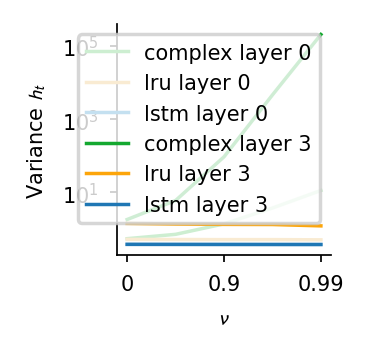

In [7]:
results = pd.DataFrame(result, columns=["rnn", "time", "batch", "layer", "mean_activation"])

colors_RNN = {
    "complex": ["#CDEED1", "#14A82F"],
    "lru": ["#F9EBD2", "#FCA50A"],
    "lstm": ["#C4E0F0", "#1F77B4"],

}

plt.figure(figsize=(1.1, 1.2))
processed_result = []
for rnn_name in rnn_names:
    for time in times:
        for l in [0, 3]:
            # selects the data
            data = results[(results["rnn"] == rnn_name) & (results["time"] == time) & (results["layer"] == l)]
            processed_result.append([rnn_name, time, l, np.mean(data["mean_activation"])])

processed_result = pd.DataFrame(processed_result, columns=["rnn", "time", "layer", "mean_activation"])


for l in [0, 3]:
    for rnn_name in rnn_names:
        data = processed_result[(processed_result["rnn"] == rnn_name) & (processed_result["layer"] == l)]
        plt.plot(data["time"], data["mean_activation"], label=f"{rnn_name} layer {l}", c=colors_RNN[rnn_name][l//2])

plt.legend()
plt.ylabel("Variance $h_t$")
plt.xlabel(r"$\nu$")
plt.xscale("log")
plt.xticks([1, 10, 100], [0, 0.9, 0.99])
plt.yscale("log")
plt.minorticks_off()

In [42]:
def loss(params, model, inputs):
    preds = model.apply(params, inputs, mutable=['batch_stats'])[0][0]
    return 0.5 * jnp.mean((preds[:, 1:] - inputs[:, :-1])**2)  # next token prediction

# Initialize the model
times = [1, jnp.power(10, 0.5), 10, jnp.power(10, 1.5), 100]

rnn_names = ["lru", "complex", "gru"]
result = []

for rnn_name in ["gru"]: #rnn_names:
    for time in times:
        print(rnn_name, time)
        t_min, t_max = time, time * 2
        min_nu = 1 - (1 / t_min)
        max_nu = 1 - (1 / t_max)
        if rnn_name == "gru":
            rnn = partial(RNN, d_hidden=d_model, T_min=t_min, T_max=t_max, cell_type=ChronoGRUCell)
        elif rnn_name == "lru":
            rnn = partial(LRU, d_input=d_model, d_hidden=d_model, d_output=d_model, min_nu=min_nu, max_nu=max_nu, which_gamma="learned", parametrization="exp")
        elif rnn_name == "complex":
            rnn = partial(LRU, d_input=d_model, d_hidden=d_model, d_output=d_model, min_nu=min_nu, max_nu=max_nu, which_gamma="none", parametrization="default")

        model = FullModel(
            rnn = rnn,
            d_model=256,
            d_output=inputs.shape[-1],  # predicting the embedding and not the full vector to make it less memory intensive
            n_layers=4,
            norm="none",
        )

        params = model.init(jax.random.PRNGKey(seed), inputs[:batch_size])
        for i in range(n_samples // batch_size):
            grad = jax.grad(loss)(params, model, inputs[i*16:(i+1)*16])

            if rnn_name in ["lru", "complex"]:
                grad_wo_lambda = remove_matching_leaves(grad, "lambda")
                flat = jax.flatten_util.ravel_pytree(grad_wo_lambda)[0]
                layer_wise = [
                    grad_wo_lambda["params"]["layers_%d"%i] for i in range(4)
                ]
                res = { "all_but_lambda": jnp.mean(flat**2) }
                res_layer_wise = {"all_but_lambda_%d"%i : jnp.mean(jax.flatten_util.ravel_pytree(layer_wise[i])[0]**2) for i in range(4)}
                res = {**res, **res_layer_wise}
                grad_lambda = select_matching_leaves(grad, "lambda")
                if rnn_name == "lru":
                    flat_nu = jax.flatten_util.ravel_pytree(jax.tree.map(lambda x: x[0], grad_lambda))[0]
                    flat_theta = jax.flatten_util.ravel_pytree(jax.tree.map(lambda x: x[1], grad_lambda))[0]
                    res = {**res, "nu": jnp.mean(flat_nu**2), "theta": jnp.mean(flat_theta**2)}
                    # same but layerwise
                    layer_wise_nu = [
                        jax.tree.map(lambda x: x[0], grad_lambda["params"]["layers_%d"%i]) for i in range(4)
                    ]
                    layer_wise_theta = [
                        jax.tree.map(lambda x: x[1], grad_lambda["params"]["layers_%d"%i]) for i in range(4)
                    ]
                    res_layer_wise_nu = {"nu_%d"%i : jnp.mean(jax.flatten_util.ravel_pytree(layer_wise_nu[i])[0]**2) for i in range(4)}
                    res_layer_wise_theta = {"theta_%d"%i : jnp.mean(jax.flatten_util.ravel_pytree(layer_wise_theta[i])[0]**2) for i in range(4)}
                    res = {**res, **res_layer_wise_nu, **res_layer_wise_theta}
                else:
                    flat_lambda = jax.flatten_util.ravel_pytree(grad_lambda)[0]
                    layer_wise_lambda = [
                        grad_lambda["params"]["layers_%d"%i] for i in range(4)
                    ]
                    res_layer_wise_lambda = {"lambda_%d"%i : jnp.mean(jax.flatten_util.ravel_pytree(layer_wise_lambda[i])[0]**2) for i in range(4)}
                    res = {**res, "lambda": jnp.mean(flat_lambda**2), **res_layer_wise_lambda}
            if rnn_name in ["gru"]:
                grad_wo_seq = remove_matching_leaves(grad, "seq")
                grad_seq = select_matching_leaves(grad, "seq")
                layer_wise_wo_seq = [
                    grad_wo_seq["params"]["layers_%d"%i] for i in range(4)
                ]
                layer_wise_seq = [
                    grad_seq["params"]["layers_%d"%i] for i in range(4)
                ]
                res_layer_wise_wo_seq = {"all_but_seq_%d"%i : jnp.mean(jax.flatten_util.ravel_pytree(layer_wise_wo_seq[i])[0]**2) for i in range(4)}
                res_layer_wise_seq = {"seq_%d"%i : jnp.mean(jax.flatten_util.ravel_pytree(layer_wise_seq[i])[0]**2) for i in range(4)}
                res = {"seq": jnp.mean(jax.flatten_util.ravel_pytree(grad_seq)[0]**2), "all_but_seq": jnp.mean(jax.flatten_util.ravel_pytree(grad_wo_seq)[0]**2)}
                res = {**res, **res_layer_wise_wo_seq, **res_layer_wise_seq}
            result.append([rnn_name, time, i, res])

lru 1
lru 3.162277660168379
lru 10
lru 31.622776601683793
lru 100
complex 1
complex 3.162277660168379
complex 10
complex 31.622776601683793
complex 100
gru 1
gru 3.162277660168379
gru 10
gru 31.622776601683793
gru 100


lru all_but_lambda
lru nu
lru theta
complex all_but_lambda
complex lambda
gru seq
gru all_but_seq


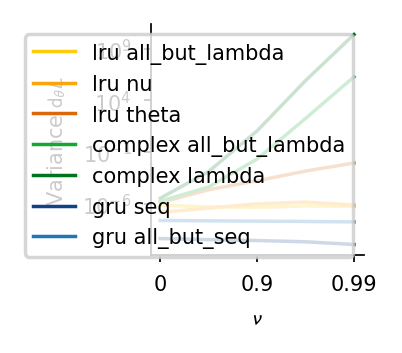

In [35]:
results = pd.DataFrame(result, columns=["rnn", "time", "batch", "mean_grad"])

colors_RNN = {
    "lru": ["#FCCB0A", "#FCA50A", "#DB680A"],
    "complex": ["#14A82F", "#02741E"],
    "gru": ["#10418B", "#1F77B4"]
}

plt.figure(figsize=(1.1, 1.2))
processed_result = []
for rnn_name in rnn_names:
    for time in times:
        # selects the data
        data = results[(results["rnn"] == rnn_name) & (results["time"] == time)]
        keys = list(data["mean_grad"])[-1].keys()
        for k in keys:
            # only take keys that don't end with a number
            if not k[-1].isdigit():
                processed_result.append([rnn_name, time, k, np.mean(data["mean_grad"].apply(lambda x: x[k]))])

processed_result = pd.DataFrame(processed_result, columns=["rnn", "time", "type", "mean_grad"])

for rnn_name in rnn_names:
    data = processed_result[(processed_result["rnn"] == rnn_name)]
    for i, ty in enumerate(data["type"].unique()):
        print(rnn_name, ty)
        sub_data = data[(data["type"] == ty)]
        plt.plot(sub_data["time"], sub_data["mean_grad"], label=f"{rnn_name} {ty}", c=colors_RNN[rnn_name][i])

plt.legend()
plt.ylabel(r"Variance $\mathrm{d}_\theta L$")
plt.xlabel(r"$\nu$")
plt.yscale("log")
plt.xscale("log")
plt.xticks([1, 10, 100], [0, 0.9, 0.99])
plt.minorticks_off()

plt.savefig("raw/RNNs_figure5_raw_p2.pdf", bbox_inches="tight", dpi=300)

    rnn                time            type layer     mean_grad
0   lru                   1  all_but_lambda     0  4.443435e-07
1   lru                   1  all_but_lambda     1  4.882910e-07
2   lru                   1  all_but_lambda     2  5.048061e-07
3   lru                   1  all_but_lambda     3  5.126159e-07
4   lru                   1              nu     0  8.631284e-08
5   lru                   1              nu     1  1.035818e-07
6   lru                   1              nu     2  1.025119e-07
7   lru                   1              nu     3  2.568577e-07
8   lru                   1           theta     0  5.755510e-07
9   lru                   1           theta     1  7.747572e-07
10  lru                   1           theta     2  1.570651e-06
11  lru                   1           theta     3  1.968102e-06
12  lru   3.162277660168379  all_but_lambda     0  2.826447e-07
13  lru   3.162277660168379  all_but_lambda     1  3.095619e-07
14  lru   3.162277660168379  all_but_lam

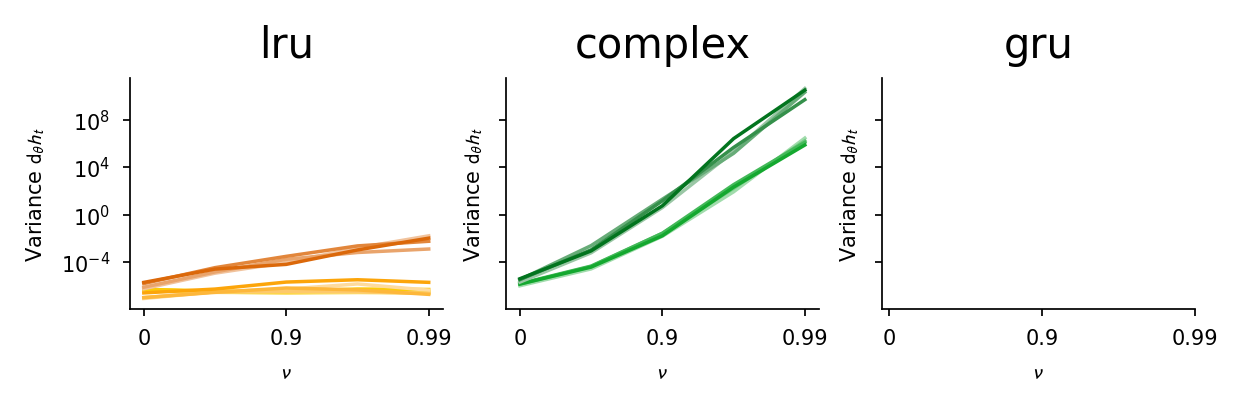

In [43]:
import matplotlib.colors


fig, ax = plt.subplots(1, 3, figsize=(5.5, 1.2), sharey=True)

processed_result = []
for rnn_name in rnn_names:
    for time in times:
        # selects the data
        data = results[(results["rnn"] == rnn_name) & (results["time"] == time)]
        keys = list(data["mean_grad"])[-1].keys()
        for k in keys:
            # only take keys that end with a number
            if k[-1].isdigit():
                processed_result.append([rnn_name, time, k[:-2], k[-1], np.mean(data["mean_grad"].apply(lambda x: x[k]))])

processed_result = pd.DataFrame(processed_result, columns=["rnn", "time", "type", "layer", "mean_grad"])

for i, rnn_name in enumerate(rnn_names):
    data = processed_result[(processed_result["rnn"] == rnn_name)]
    print(data)
    for j, ty in enumerate(data["type"].unique()):
        for l in range(4):
            sub_data = data[(data["layer"] == str(l)) & (data["type"] == ty)]
            # Interpolate the color between white and colors_RNN[rnn_name][j]
            color = matplotlib.colors.to_hex(np.array([1, 1, 1]) * ((3-l)/5) + np.array(matplotlib.colors.to_rgb(colors_RNN[rnn_name][j])) * (1 - (3-l)/5))
            ax[i].plot(sub_data["time"], sub_data["mean_grad"], label=f"layer {l}", c=color)
    ax[i].set_title(rnn_name)
    ax[i].set_yscale("log")
    ax[i].set_xscale("log")
    ax[i].set_xticks([1, 10, 100])
    ax[i].set_xticklabels([0, 0.9, 0.99])
    ax[i].minorticks_off()
    ax[i].set_xlabel(r"$\nu$")
    ax[i].set_ylabel(r"Variance $\mathrm{d}_\theta h_t$")
    # ax[i].legend()

In [10]:
# Effect normalization

times = [1, jnp.power(10, 0.5), 10, jnp.power(10, 1.5), 100]

norms = ["batch", "none", "layer"]
result = []

for norm in norms:
    for time in times:
        print(norm, time)
        t_min, t_max = time, time * 2
        min_nu = 1 - (1 / t_min)
        max_nu = 1 - (1 / t_max)
        rnn = partial(LRU, d_input=d_model, d_hidden=d_model, d_output=d_model, min_nu=min_nu, max_nu=max_nu, which_gamma="none", parametrization="default")

        model = FullModel(
            rnn = rnn,
            d_model=256,
            d_output=inputs.shape[-1],  # predicting the embedding and not the full vector to make it less memory intensive
            n_layers=4,
            norm=norm,
        )

        # batch_size = 8

        params = model.init(jax.random.PRNGKey(seed), inputs[:batch_size])
        for i in range(n_samples // batch_size):
            outputs = model.apply(params, inputs[i*batch_size//2:(i+1)*batch_size], mutable=['batch_stats'])[0][1]
            res = {"mean_output": jnp.mean(outputs[-1]**2)}
            grad = jax.grad(loss)(params, model, inputs[i*batch_size:(i+1)*batch_size])
            grad_wo_lambda = remove_matching_leaves(grad, "lambda")
            flat = jax.flatten_util.ravel_pytree(grad_wo_lambda)[0]
            res = {**res, "all_but_lambda": jnp.mean(flat**2) }
            grad_lambda = select_matching_leaves(grad, "lambda")
            flat_lambda = jax.flatten_util.ravel_pytree(grad_lambda)[0]
            res = {**res, "lambda": jnp.mean(flat_lambda**2)}
        result.append([norm, time, i, res])

batch 1


batch 3.162277660168379
batch 10
batch 31.622776601683793
batch 100
none 1
none 3.162277660168379
none 10
none 31.622776601683793
none 100
layer 1
layer 3.162277660168379
layer 10
layer 31.622776601683793
layer 100


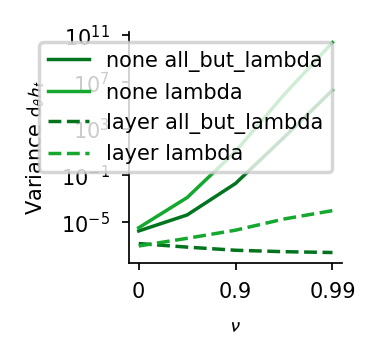

In [11]:
results = pd.DataFrame(result, columns=["norm", "time", "batch", "info"])

colors_RNN = {
    "batch": ["#FCCB0A", "#FCA50A", "black"],
    "none": ["#14A82F", "#02741E", "black"],
    "layer": ["#14A82F", "#02741E", "black"],
}

plt.figure(figsize=(1.1, 1.2))
processed_result = []
for norm in norms:
    for time in times:
        # selects the data
        data = results[(results["norm"] == norm) & (results["time"] == time)]
        keys = list(data["info"])[-1].keys()
        for k in keys:
            processed_result.append([norm, time, k, np.mean(data["info"].apply(lambda x: x[k]))])

processed_result = pd.DataFrame(processed_result, columns=["norm", "time", "type", "mean"])

for norm in ["none", "layer"]:  # batch is the same as layer
    data = processed_result[(processed_result["norm"] == norm)]
    for i, ty in enumerate(data["type"].unique()):
        if ty != "mean_output":
            sub_data = data[(data["type"] == ty)]
            style = "-" if norm == "none" else "--"
            plt.plot(sub_data["time"], sub_data["mean"], label=f"{norm} {ty}", ls=style, c=colors_RNN[norm][i%2])

plt.legend()
plt.ylabel(r"Variance $\mathrm{d}_\theta h_t$")
plt.xlabel(r"$\nu$")
plt.xscale("log")
plt.xticks([1, 10, 100], [0, 0.9, 0.99])
plt.yscale("log")
plt.minorticks_off()